In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from statsmodels.distributions.empirical_distribution import ECDF
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(png_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/calc_value_growth_history.py

## Input

In [4]:
chain = 'Arbitrum'

In [5]:
reward_token = 'AVAX' if chain == 'Avalanche' else 'ETH'

In [6]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
    if fname.startswith('AUM & Glp Supply'):
        fnames['AUM & Glp Supply'] = fname
    if fname.startswith('Fees'):
        fnames['Fees'] = fname                
fnames

{'Glp Price Comparison': 'Glp Price Comparison_2021-08-31_2022-07-18.csv',
 'AUM & Glp Supply': 'AUM & Glp Supply_2021-08-31_2022-07-17.csv',
 'Fees': 'Fees_2021-08-31_2022-07-18.csv'}

## Prep Data

In [7]:
# read GLP price data
glp_prices = (pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                         index_col='Date', parse_dates=['Date'])
                .iloc[:-1, ] # drop the last row since it may not be a full day
                .loc[:, ['glpPrice', 'glpPlusFees']]
                .rename(columns={'glpPrice':'glp_price', 'glpPlusFees':'glp_plusfees_price'})
             )
glp_prices.tail()

,glp_price,glp_plusfees_price
Date,,
2022-07-13,0.7952,1.1027
2022-07-14,0.8144,1.1223
2022-07-15,0.8233,1.1315
2022-07-16,0.8519,1.1605
2022-07-17,0.8467,1.1556


In [8]:
# read glp supply data
glp_supply = (pd.read_csv(os.path.join(data_dir, chain, fnames['AUM & Glp Supply']), 
                           parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpSupply'])
                .iloc[:-1, ] # drop the last row since it may not be a full day
                .rename(columns={'glpSupply':'glp_supply'})
                .squeeze()
              )
glp_supply.tail()

Date
2022-07-12   207,364,117.3556
2022-07-13   208,514,784.6535
2022-07-14   206,712,260.9179
2022-07-15   208,781,948.5548
2022-07-16   211,664,533.8572
Name: glp_supply, dtype: float64

In [9]:
# # calculate daily GLP pool dollar value
# glp_pool_value = glp_prices['glp_price'] * glp_supply
# glp_pool_value.name = 'glp_pool_value'
# glp_pool_value

In [10]:
# read fees data
fees = (pd.read_csv(os.path.join(data_dir, chain, fnames['Fees']), 
                    parse_dates=['Date'], index_col='Date', 
                    # ignore the last col "Cumulative" cuz it's NOT the daily total, but cumulative daily total 
                    usecols=range(6))
          .iloc[:-1, ] # drop the last row since it may not be a full day
       )
fees.columns = fees.columns.str.lower().str.replace(' ', '_') + '_fees'
# calc daily total 
fees['total_fees'] = fees.sum(axis=1)
fees.tail()

,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees
Date,,,,,,
2022-07-13,"26,039.8605","98,998.6957","2,175.8990","4,235.3280","1,165.1310","132,614.9142"
2022-07-14,"20,784.1587","102,587.1863","1,163.2054",628.6233,"1,430.1843","126,593.3580"
2022-07-15,"21,271.8336","86,887.6048",470.4649,"2,079.8992",948.2421,"111,658.0445"
2022-07-16,"11,555.3853","84,354.6200","2,906.6752",511.7381,"4,544.4597","103,872.8784"
2022-07-17,"16,260.6610","81,360.0278","1,141.8855","1,011.7876",231.5111,"100,005.8730"


In [11]:
# how much fees (in dollars) does 1 GLP earn? Think of it as daily dividend
fees_per_share = fees['total_fees'] * 0.7 / glp_supply
fees_per_share.name = 'fees_per_share'
fees_per_share

Date
2021-08-31   0.0001
2021-09-01   0.0042
2021-09-02   0.0014
2021-09-03   0.0020
2021-09-04   0.0004
              ...  
2022-07-13   0.0004
2022-07-14   0.0004
2022-07-15   0.0004
2022-07-16   0.0003
2022-07-17      NaN
Name: fees_per_share, Length: 321, dtype: float64

## Set up 

allow users to enter their own numbers and see output

In [12]:
# user input
start_date = glp_prices.index[0]     # investment start date, can use a date string, for example, '2022-06-15'
init_capital = 10_000                # dollars

In [13]:
# what's my purchase price?
init_price = glp_prices.loc[start_date, 'glp_price'] # use the avg daily price on start date 
# how much GLP did I buy?
init_shares = init_capital / init_price
print('Purchase price: ${:.3f}'.format(init_price), 'Shares: {:.4f}'.format(init_shares))

Purchase price: $1.194 Shares: 8378.4168


In [14]:
res = dict() # hold output growth paths

## Reinvest Rewards

In [15]:
value_growth_daily_compounded = calc_value_growth_history(glp_prices.glp_plusfees_price, start_date, init_capital)
value_growth_daily_compounded

Investment started on 2021-08-31 00:00:00 



2021-08-31   10,000.0000
2021-09-01   10,861.1156
2021-09-02   10,827.2035
2021-09-03   10,989.3746
2021-09-04   11,004.1827
                 ...    
2022-07-13    9,238.8084
2022-07-14    9,403.0884
2022-07-15    9,480.5798
2022-07-16    9,723.3437
2022-07-17    9,682.4158
Name: value, Length: 321, dtype: float64

In [16]:
name = 'Reinvest {} rewards daily'.format(reward_token)
res[name] = value_growth_daily_compounded

In [17]:
# double check by running through the calculation of manually reinvesting fees daily and compounding
daily_shares = [init_shares]
subdf_prices = glp_prices.loc[start_date:]

for i in range(len(subdf_prices)-1):
    shares_today = daily_shares[-1] # assume we buy shares at day end so we don't earn any fees today
    # our shares start earning fees tomorrow. This is to match with the data which gives the same
    # glp_price and glp_plusfees_price at inception.
    fees_earned_tomorrow = fees_per_share[i+1] * shares_today
    price_tomorrow = subdf_prices.glp_price[i+1]
    daily_shares.append(shares_today + fees_earned_tomorrow / price_tomorrow)
daily_shares = pd.Series(daily_shares)

# calc daily values
daily_shares * subdf_prices.glp_price.values

0     10,000.0000
1     10,871.1167
2     10,840.5604
3     11,008.1399
4     11,024.1162
          ...    
316    9,013.9505
317    9,236.1990
318    9,341.0894
319    9,669.8382
320           NaN
Length: 321, dtype: float64

In [18]:
value_growth_daily_compounded

2021-08-31   10,000.0000
2021-09-01   10,861.1156
2021-09-02   10,827.2035
2021-09-03   10,989.3746
2021-09-04   11,004.1827
                 ...    
2022-07-13    9,238.8084
2022-07-14    9,403.0884
2022-07-15    9,480.5798
2022-07-16    9,723.3437
2022-07-17    9,682.4158
Name: value, Length: 321, dtype: float64

our manually calculation and the calculation using `glp_plusfees_price` give similar results. The differences are probably due to `glp_plusfees_price` more accurately reflect reality. For example, it might've factored fees into prices at a more granular frequency as hourly, minutely, or secondly. 

## Sell rewards into USD instead of reinvesting into GLP

In [19]:
# calc investment value due to GLP price movement
value_growth_price_driven = calc_value_growth_history(glp_prices.glp_price, start_date, init_capital)
value_growth_price_driven

Investment started on 2021-08-31 00:00:00 



2021-08-31   10,000.0000
2021-09-01   10,836.1130
2021-09-02   10,793.5653
2021-09-03   10,944.0314
2021-09-04   10,956.1517
                 ...    
2022-07-13    6,662.8673
2022-07-14    6,823.5555
2022-07-15    6,897.9103
2022-07-16    7,137.7961
2022-07-17    7,094.1106
Name: value, Length: 321, dtype: float64

In [20]:
# how much fees do we earn per day?
fees_earned = fees_per_share.loc[start_date:] * init_shares

# assume we don't earn any fees on day1. We do this to match up the data. The glp_price and 
# glp_plusfees_price are the same on day1 => this is a good assumption. 
fees_earned[0] = 0

# # alternatively, we could assume fees we earn today is distributed to us tomorrow so we need to shift the data by 1 day.
# # the output under both assumptions don't show difference when plotted out.
# fees_earned = fees_earned.shift(1).fillna(0)

fees_earned

Date
2021-08-31    0.0000
2021-09-01   35.0036
2021-09-02   12.0899
2021-09-03   16.3870
2021-09-04    3.7629
               ...  
2022-07-13    3.7301
2022-07-14    3.5917
2022-07-15    3.1366
2022-07-16    2.8782
2022-07-17       NaN
Name: fees_per_share, Length: 321, dtype: float64

In [21]:
# add money earned from trader and fees to investment value determined by price alone
value_growth_no_compounding = value_growth_price_driven + fees_earned # + traders_money_earned
value_growth_no_compounding.name = 'value'
value_growth_no_compounding

2021-08-31   10,000.0000
2021-09-01   10,871.1167
2021-09-02   10,805.6552
2021-09-03   10,960.4183
2021-09-04   10,959.9145
                 ...    
2022-07-13    6,666.5973
2022-07-14    6,827.1473
2022-07-15    6,901.0469
2022-07-16    7,140.6742
2022-07-17           NaN
Name: value, Length: 321, dtype: float64

In [22]:
name = 'Sell {} rewards into USD daily'.format(reward_token)
res[name] = value_growth_no_compounding

## Compare

In [23]:
df = pd.DataFrame(res)
df

,Reinvest ETH rewards daily,Sell ETH rewards into USD daily
2021-08-31,"10,000.0000","10,000.0000"
2021-09-01,"10,861.1156","10,871.1167"
2021-09-02,"10,827.2035","10,805.6552"
2021-09-03,"10,989.3746","10,960.4183"
2021-09-04,"11,004.1827","10,959.9145"
...,...,...
2022-07-13,"9,238.8084","6,666.5973"
2022-07-14,"9,403.0884","6,827.1473"
2022-07-15,"9,480.5798","6,901.0469"
2022-07-16,"9,723.3437","7,140.6742"


In [24]:
last_day = df.index[-1]

In [25]:
df_long = df.stack().to_frame().reset_index()
df_long.columns = ['Date', 'Strategy', 'Investment Value']
df_long.head()

,Date,Strategy,Investment Value
0,2021-08-31,Reinvest ETH rewards daily,"10,000.0000"
1,2021-08-31,Sell ETH rewards into USD daily,"10,000.0000"
2,2021-09-01,Reinvest ETH rewards daily,"10,861.1156"
3,2021-09-01,Sell ETH rewards into USD daily,"10,871.1167"
4,2021-09-02,Reinvest ETH rewards daily,"10,827.2035"


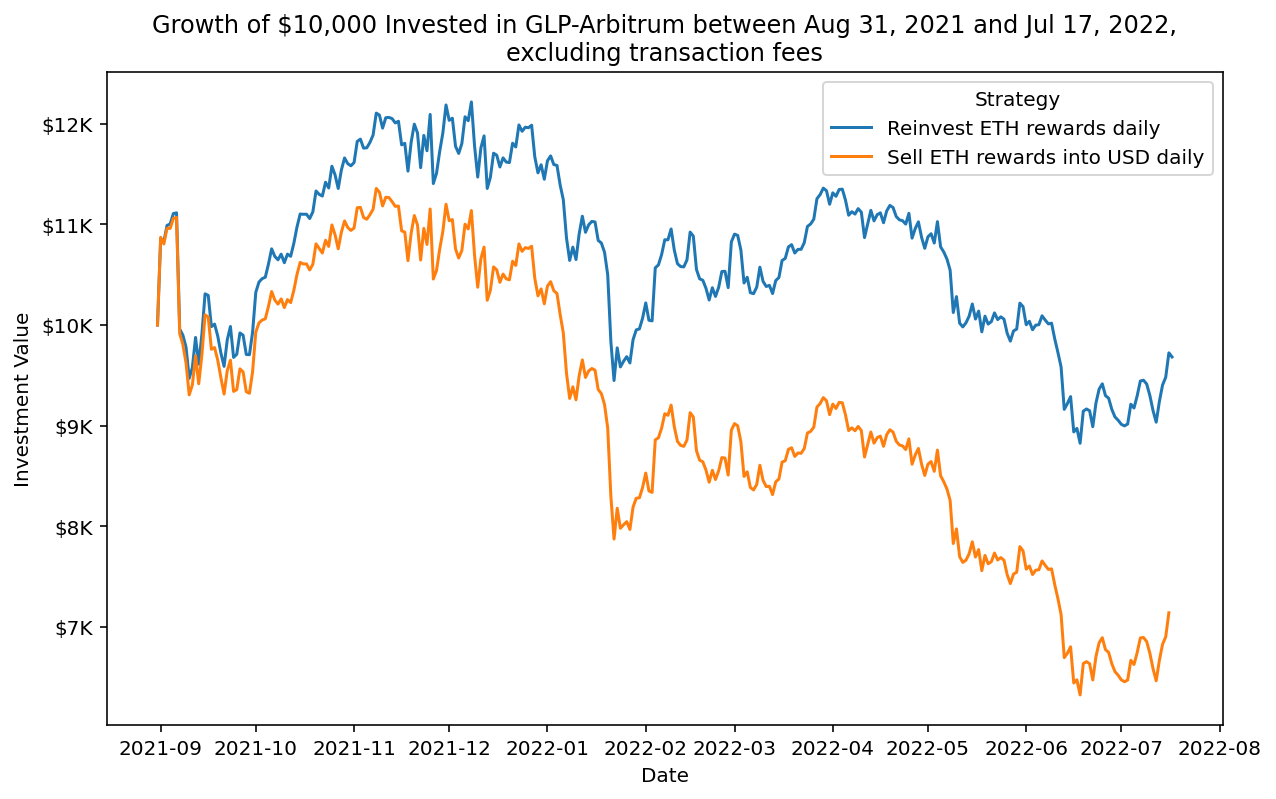

In [26]:
ax = sns.lineplot(data=df_long, x='Date', y='Investment Value', hue='Strategy')
ax.set(title="Growth of ${:,} Invested in GLP-{} between {} and {},\nexcluding transaction fees".format(init_capital, chain, start_date.strftime('%b %d, %Y'), last_day.strftime('%b %d, %Y'), reward_token))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

fname = 'glp_compare_2strats_since_{}.png'.format(start_date.strftime('%b %d, %Y'))
plt.savefig(os.path.join(png_dir, chain, fname), dpi=300);